# Social Reward Second Level Analyses

## Set Up

### Import packages

In [1]:
import os
import glob
import pandas as pd
import numpy as np

from matplotlib.gridspec import GridSpec

# Import cerebellum packages
import matplotlib.pyplot as plt
import SUITPy.flatmap as flatmap

from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img, cluster_level_inference



### Define Functions

In [19]:
def plot_transparent_threshold(filename, thresh=1, mc='fdr', mc_alpha=0.05, clust_alpha=0.05, view='split', title=''):
    # Find type of analysis
    analysis = 'group'
    
    # Find stat map
    stat_filename = os.path.join(data_dir, analysis,  
                                    filename+'_effect.nii.gz')
    #stat_filename_mc = os.path.join(data_dir, analysis,  
    #                                filename+'_'+mc+'-'+str(mc_alpha)+'_clust-'+str(clust_alpha)+'.nii.gz')
    stat_filename_mc = os.path.join(data_dir, analysis,  
                                    filename+'_zmap_'+mc+'-'+str(mc_alpha)+'.nii.gz')
    
    # Import stat map as a cerebellum flatmap
    funcdata = flatmap.vol_to_surf(stat_filename,
                                  space='SUIT')
    
    
    
    mc_thresh = threshold_data[filename+'_zmap_'+mc+'-'+str(mc_alpha)]
    print(mc_thresh)
    if mc_thresh == np.inf:
        mc_thresh = 1000

    if view == 'split':
        # Set figure specs
        fig = plt.figure(figsize=(15, 4))
        gs = GridSpec(2, 3)
        ax_img1 = plt.subplot(gs[0, :2])
        ax_img2 = plt.subplot(gs[1, :2])
        
        hemi_lh = plot_stat_map(stat_filename, threshold=thresh, axes=ax_img1,
                                cut_coords=range(-65,0, 10), display_mode='x', colorbar=True,
                                cmap='coolwarm', symmetric_cbar=True, title='Left Hemisphere',
                                annotate=False)
        hemi_rh = plot_stat_map(stat_filename, threshold=thresh, axes=ax_img2,
                                cut_coords=range(66,5, -10), display_mode='x', colorbar=True,
                                cmap='coolwarm', symmetric_cbar=True, title='Right Hemisphere',
                                annotate=False)
        hemi_lh.add_contours(stat_filename_mc, levels=[-0.1,0.1], colors=['blue','red'], 
                          alpha=1, linewidths=1)
        hemi_rh.add_contours(stat_filename_mc, levels=[-0.1,0.1], colors=['blue','red'], 
                          alpha=1, linewidths=1)
        
        ax_joint = plt.subplot(gs[:, 2:])
        ax_joint.set(title='Cerebellum flatmap')
        flatmap.plot(data=funcdata, cmap='coolwarm', 
                    threshold=[-thresh,thresh],
                    colorbar=False, render='matplotlib', new_figure=False)
        
    elif view == 'straight':
        hemi_bh = plot_stat_map(stat_filename, threshold=thresh, 
                      cut_coords=range(-65,66, 10), display_mode='x', colorbar=True,
                      cmap='coolwarm', symmetric_cbar=True, title=title)
        hemi_bh.add_contours(stat_filename_mc, levels=[-0.1,0.1], colors=['blue','red'], 
                          alpha=1, linewidths=2)

### Set directories and import subject data

In [3]:
#bids_dir = '/data/projects/social_doors/'
bids_dir = '/data/neuron/SCN/SR/'


os.chdir(bids_dir)

data_dir = os.path.join(bids_dir, 'derivatives','rl_modeling')
outp_dir = data_dir+'group/'

# Import scan info for runs that passed QC
subjs_scan_info = pd.read_csv(bids_dir+'/derivatives/participants_good.csv')

# Create a participant list for only those with good scans
subjs_list = list(subjs_scan_info['participant_id'].unique())
subjs_list.sort()

# Import other participant info like demographics
subjs_info = pd.read_csv(bids_dir+'participants.tsv', sep='\t', index_col=0)
#subjs_info = subjs_info.rename(columns={'participant_id': 'subject_label'})

# Filter for only participants with good scan data
subjs_info = subjs_info.loc[subjs_list]

# Rename group IDs
subjs_info['group'] = subjs_info['group'].map({1: 'not_asd', 2: 'asd'})

# Reset index to make participant IDs a column
subjs_info = subjs_info.reset_index()


subjs_info_typ = subjs_info[subjs_info['group']=='not_asd']
subjs_info_asd = subjs_info[subjs_info['group']=='asd']

#subjs_list = subjs_info.index.to_list()
subjs_list_typ = subjs_info_typ['participant_id'].to_list()
subjs_list_asd = subjs_info_asd['participant_id'].to_list()

print('Found '+str(len(subjs_list_typ))+' non-autistic participants')
print('Found '+str(len(subjs_list_asd))+' autistic participants')

Found 52 non-autistic participants
Found 21 autistic participants


# Non-Autistic Adolescents

<Axes: label='conditions', ylabel='scan number'>

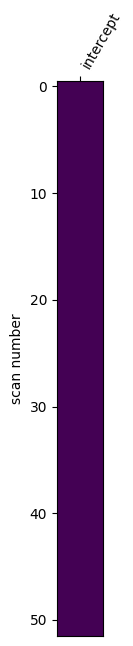

In [4]:
design_matrix = make_second_level_design_matrix(subjs_list_typ)

plot_design_matrix(design_matrix)

In [5]:
mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['RPE']
group = 'not_asd'
tasks = ['SR']
alpha = 0.05
mc = 'fdr'


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        temp_subj_list = subjs_list_typ.copy()
        temp_file_list = []
        for subj in subjs_list_typ:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii.gz'))
            if len(temp_file) == 0:
                temp_subj_list.remove(subj)
                continue
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        print('Calculating group '+contrast+' contrast')
        
        design_matrix = make_second_level_design_matrix(temp_subj_list)
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        contrast_stats = model.compute_contrast(output_type='all')
        z_map = contrast_stats['z_score']
        e_map = contrast_stats['effect_size']

        z_map.to_filename(os.path.join(data_dir,'group',
                                   group+'_'+task+'_'+contrast+'_zmap.nii.gz'))
        e_map.to_filename(os.path.join(data_dir,'group',
                                   group+'_'+task+'_'+contrast+'_effect.nii.gz'))
            
        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)
        #z_map_thresh_clust = cluster_level_inference(z_map_thresh, alpha=0.05)
        z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                   group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))
        #z_map_thresh_clust.to_filename(os.path.join(data_dir,'group',
        #                           'zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)+'_clust-0.05'+'.nii.gz'))
            
        threshold_data[group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)] = threshold
        

Calculating group RPE contrast


### Reward Prediction Error

3.1277033806832253


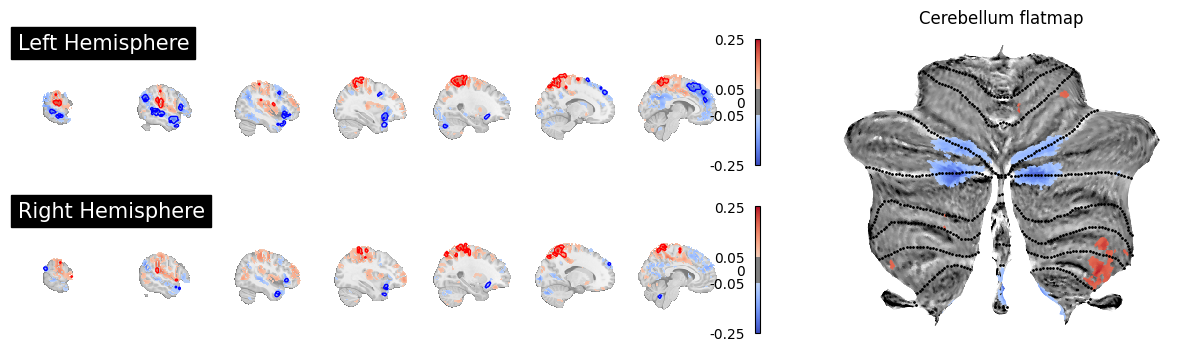

In [6]:
filename = 'not_asd_SR_RPE'

plot_transparent_threshold(filename, thresh=.05)